In [1]:
import numpy as np
import scipy.io as scio
# import scipy.sparse as sp
# import hdf5storage # get code on https://pypi.python.org/pypi/hdf5storage/0.1.3
# import networkx as nx

import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 写入mat
def WriteMatlab(data_np, VarName, FileName):
    matcontent = {}
    matcontent[VarName] = data_np
    hdf5storage.write(matcontent, filename=FileName, matlab_compatible=True)

In [4]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/BA_2000_6.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'],dtype=int)
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_10_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'],dtype=int)
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size doesn\'t match!"

assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"

if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [5]:
# 参数设置

# 0. 公共参数
Monte_Carlo_loop = 100     # 蒙特卡洛模拟次数
time_steps = 100           # 总时间步数
N = network_scale_1[0]     # 网络节点数
w_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    # S-I断边概率

# 1. SIS参数
bata = 0.2    # 感染概率
mu = 0.4      # 恢复概率

# 2. UAU参数
lamda = 0.3    # 传播率
delta = 0.6    # 遗忘率

# 4. 其他参数
aplha = 0.4      # 信息上传率
iter_ = 0

infective_count_average_total = np.zeros([len(w_list), time_steps])
awareness_count_average_total = np.zeros([len(w_list), time_steps])

In [6]:
for w in w_list:
    
    time_start_w = time.time()
    
    random.seed(512)
    np.random.seed(512)

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)                # 记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)             # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])


    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])



    time_start = time.time()

    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        network_physical_t = np.zeros([time_steps, N, N],dtype=int)    # 每一步接触网络的快照
        network_physical_t[0,:,:] = network_physical[:, :]             # 每一步初始时刻接触网络为原始网络


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    a_1 = 1 - (1 - lamda) ** Num_neighbor_listener    # 最终计算的传播率
                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a_1:
                        Nodes_UAU[loop, t+1, i] = 1
                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘
                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉 


            # ----------更改连边----------
            for i in range(N):
                if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                    
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                    susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 0))[0]                 # 易感节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
                    # neighbor_susceptible = np.intersect1d(susceptible_nodes, neighbor_total)        # 取交集-易感邻居
                    neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 邻居里去除感染邻居-易感邻居

                    destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

                    for infectNeighbor in neighbor_infective:
                        # 如果断边成功，则在当前时刻更改连接
                        if np.random.rand(1) <= w:
                            network_physical_t[t,i,infectNeighbor] = 0
                            network_physical_t[t,infectNeighbor,i] = 0

                            destination = random.choice(destinations)
                            destinations.remove(destination)

                            network_physical_t[t,i,destination] = 1
                            network_physical_t[t,destination,i] = 1

            # ----------SIS演化----------
            for i in range(N):

            # # 0代表易感(S)，如果节点是US，则不做改变，正常感染
            # if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 0)):

                if Nodes_SIS[loop, t, i] == 0:

                    neighbor_total = np.where((network_physical_t[t, i, :] == 1))[0]          # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]               # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)      # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                          # 统计数量

                    # -----SIS感染过程1-----
                    # SIS感染率
                    v_1 = 1 - (1 - bata) ** Num_neighbor_infective
                    p = np.random.rand(1)
                    if p <= v_1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")

            # 将当前时间的接触网络复制到下一时刻
            network_physical_t[t+1,:,:] = network_physical_t[t,:,:]

        # 保存本次蒙特卡洛循环产生的接触网络数据
        # addr_mat = '../results/loop/'+'loop_'+str(loop)+'.mat'
        # # addr_csv = '../results/loop/'+'loop_'+str(loop)+'.csv'
        # name = 'loop_'+str(loop)
        # scio.savemat(addr, {name: network_physical_t})
        # # np.savetxt(addr_csv, network_physical_t, fmt = '%d', delimiter = ',')

        print("    loop {} - time has passed: {} ".format(loop, time.time()-time_start))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    awareness_count_average = np.mean(awareness_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"

    infective_count_average_total[iter_, :] = infective_count_average/N
    awareness_count_average_total[iter_, :] = awareness_count_average/N
    iter_ += 1

    print("w = {} - time has passed: {} ".format(w, time.time()-time_start))

    loop 0 - time has passed: 54.50483274459839 
    loop 1 - time has passed: 104.29760074615479 
    loop 2 - time has passed: 163.6991889476776 
    loop 3 - time has passed: 221.70177054405212 
    loop 4 - time has passed: 272.50243186950684 
    loop 5 - time has passed: 321.2410178184509 
    loop 6 - time has passed: 370.67478919029236 
    loop 7 - time has passed: 421.90995597839355 
    loop 8 - time has passed: 470.98805356025696 
    loop 9 - time has passed: 519.3889932632446 
    loop 10 - time has passed: 565.479730129242 
    loop 11 - time has passed: 610.8910322189331 
    loop 12 - time has passed: 655.8830678462982 
    loop 13 - time has passed: 700.7747349739075 
    loop 14 - time has passed: 745.2379930019379 
    loop 15 - time has passed: 826.6273255348206 
    loop 16 - time has passed: 871.8895661830902 
    loop 17 - time has passed: 916.6285753250122 
    loop 18 - time has passed: 962.7059187889099 
    loop 19 - time has passed: 1006.7702257633209 
    

    loop 63 - time has passed: 3159.2546763420105 
    loop 64 - time has passed: 3205.350619316101 
    loop 65 - time has passed: 3250.079451084137 
    loop 66 - time has passed: 3295.335335969925 
    loop 67 - time has passed: 3340.8822541236877 
    loop 68 - time has passed: 3385.0121550559998 
    loop 69 - time has passed: 3430.322528362274 
    loop 70 - time has passed: 3476.361029624939 
    loop 71 - time has passed: 3522.4536554813385 
    loop 72 - time has passed: 3567.523060798645 
    loop 73 - time has passed: 3612.8837039470673 
    loop 74 - time has passed: 3657.3968806266785 
    loop 75 - time has passed: 3738.1621804237366 
    loop 76 - time has passed: 3784.26931476593 
    loop 77 - time has passed: 3829.284815788269 
    loop 78 - time has passed: 3874.514762401581 
    loop 79 - time has passed: 3919.4731509685516 
    loop 80 - time has passed: 3965.6004960536957 
    loop 81 - time has passed: 4010.7527887821198 
    loop 82 - time has passed: 4056.45777

    loop 25 - time has passed: 1235.1527650356293 
    loop 26 - time has passed: 1282.6410529613495 
    loop 27 - time has passed: 1330.76624584198 
    loop 28 - time has passed: 1378.001294374466 
    loop 29 - time has passed: 1424.7808001041412 
    loop 30 - time has passed: 1472.078313589096 
    loop 31 - time has passed: 1519.265924692154 
    loop 32 - time has passed: 1566.7107591629028 
    loop 33 - time has passed: 1615.3405454158783 
    loop 34 - time has passed: 1662.326608657837 
    loop 35 - time has passed: 1710.317155122757 
    loop 36 - time has passed: 1758.6471011638641 
    loop 37 - time has passed: 1804.8821291923523 
    loop 38 - time has passed: 1852.6944451332092 
    loop 39 - time has passed: 1900.3886604309082 
    loop 40 - time has passed: 1948.5947773456573 
    loop 41 - time has passed: 2029.641049861908 
    loop 42 - time has passed: 2077.469504594803 
    loop 43 - time has passed: 2124.4840972423553 
    loop 44 - time has passed: 2172.3754

    loop 87 - time has passed: 4556.67272233963 
    loop 88 - time has passed: 4606.233990192413 
    loop 89 - time has passed: 4655.45338511467 
    loop 90 - time has passed: 4704.200784444809 
    loop 91 - time has passed: 4785.136421203613 
    loop 92 - time has passed: 4836.464098215103 
    loop 93 - time has passed: 4884.531346797943 
    loop 94 - time has passed: 4934.405540466309 
    loop 95 - time has passed: 4982.735543727875 
    loop 96 - time has passed: 5031.531044721603 
    loop 97 - time has passed: 5081.546321153641 
    loop 98 - time has passed: 5130.3743369579315 
    loop 99 - time has passed: 5179.671130895615 
w = 0.4 - time has passed: 5179.718010425568 
    loop 0 - time has passed: 50.90651607513428 
    loop 1 - time has passed: 103.04781222343445 
    loop 2 - time has passed: 154.62593913078308 
    loop 3 - time has passed: 205.67196488380432 
    loop 4 - time has passed: 256.8130166530609 
    loop 5 - time has passed: 306.91393971443176 
    loo

    loop 49 - time has passed: 2967.3247747421265 
    loop 50 - time has passed: 3067.544839859009 
    loop 51 - time has passed: 3121.9676282405853 
    loop 52 - time has passed: 3177.434805870056 
    loop 53 - time has passed: 3230.1682250499725 
    loop 54 - time has passed: 3283.7253773212433 
    loop 55 - time has passed: 3338.1768867969513 
    loop 56 - time has passed: 3421.761777162552 
    loop 57 - time has passed: 3477.980990409851 
    loop 58 - time has passed: 3558.3723788261414 
    loop 59 - time has passed: 3610.5291159152985 
    loop 60 - time has passed: 3669.8787417411804 
    loop 61 - time has passed: 3723.588711977005 
    loop 62 - time has passed: 3776.169159889221 
    loop 63 - time has passed: 3831.1651582717896 
    loop 64 - time has passed: 3884.499298095703 
    loop 65 - time has passed: 3938.792566537857 
    loop 66 - time has passed: 3992.587683200836 
    loop 67 - time has passed: 4045.4502317905426 
    loop 68 - time has passed: 4098.0781

    loop 11 - time has passed: 777.0014181137085 
    loop 12 - time has passed: 836.5948286056519 
    loop 13 - time has passed: 899.8901352882385 
    loop 14 - time has passed: 961.265783071518 
    loop 15 - time has passed: 1023.5316309928894 
    loop 16 - time has passed: 1105.7344601154327 
    loop 17 - time has passed: 1165.4227166175842 
    loop 18 - time has passed: 1224.5796682834625 
    loop 19 - time has passed: 1284.0734288692474 
    loop 20 - time has passed: 1344.384808063507 
    loop 21 - time has passed: 1406.148567199707 
    loop 22 - time has passed: 1472.4130079746246 
    loop 23 - time has passed: 1554.8587727546692 
    loop 24 - time has passed: 1614.5157465934753 
    loop 25 - time has passed: 1678.4995803833008 
    loop 26 - time has passed: 1738.7526721954346 
    loop 27 - time has passed: 1799.6729245185852 
    loop 28 - time has passed: 1862.4078941345215 
    loop 29 - time has passed: 1923.1433365345001 
    loop 30 - time has passed: 1983.53

    loop 74 - time has passed: 5120.938230752945 
    loop 75 - time has passed: 5187.781564235687 
    loop 76 - time has passed: 5253.538101911545 
    loop 77 - time has passed: 5320.368605852127 
    loop 78 - time has passed: 5388.826072692871 
    loop 79 - time has passed: 5457.763394117355 
    loop 80 - time has passed: 5524.690187692642 
    loop 81 - time has passed: 5590.516238451004 
    loop 82 - time has passed: 5657.728198051453 
    loop 83 - time has passed: 5725.693476200104 
    loop 84 - time has passed: 5806.626296043396 
    loop 85 - time has passed: 5874.558363437653 
    loop 86 - time has passed: 5942.453258752823 
    loop 87 - time has passed: 6009.312992811203 
    loop 88 - time has passed: 6089.672665119171 
    loop 89 - time has passed: 6157.047986507416 
    loop 90 - time has passed: 6223.7154376506805 
    loop 91 - time has passed: 6289.797931671143 
    loop 92 - time has passed: 6356.109759569168 
    loop 93 - time has passed: 6422.36021733284 


In [7]:
# plt.plot(infective_count_average/N, color='blue', label='SIS')
# plt.plot(awareness_count_average/N, color='green', label='UAU')

In [8]:
addr = '../results/'
name1 = 'BA_WS_w_infective'
name2 = 'BA_WS_w_awareness'
scio.savemat(addr+name1+'.mat', {name1: infective_count_average_total})
scio.savemat(addr+name2+'.mat', {name2: awareness_count_average_total})

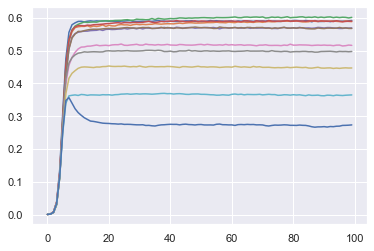

In [9]:
for w_ in range(len(w_list)):
    plt.plot(infective_count_average_total[w_,:], label=str(w_list[w_]))